Side note on process: I'm very grateful to [this site](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) for being a great resource in providing clarity on what I should be doing for a proper topical extraction. A lot of the thinking in how this was done, and walkthroughs on code implementation, were from this site.

In [1]:
#################
#IMPORTS

#os
import os

#re
import re

#Import Pandas and Numpy
import pandas as pd

#pyplot
import matplotlib.pyplot as plt

#nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 
#from nltk.stem import PorterStemmer

#Gensim
import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as lda
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


# Data 
## We are using the World English Bible (WEB) translation

Credit goes to http://www.magister.msk.ru/library/bible/english/web/web.htm for providing a simple text version of the Book of Psalms with this translation that I could simply grab.

### About WEB

* WEB is a free public domain translation of the Bible, and is an updated version of the American Standard Version (ASV).
* WEB "started in order to produce a modern English Bible version that is not copyrighted, does not use archaic English (such as the KJV), and is not translated into Basic English" (from Wikipedia)
    - Wikipedia also tells me that 'Basic English' isn't necessarily better, so I shouldn't need to seek out the Basic English version. Basic English is a simplified form of ENglish meant for ESL learners.
* I tried ASV at first, but PorterStemmer and WordNetLemmatiser do not play well with the archaic language that seems more present in ASV. E.g. stand instead of standeth failed to be lemmatised/stemmed, and it would have been impossible to pull out all instances of this

In [2]:
#################
#GETTING THE DATA

#Open the file
open_file = open('web_psalms.txt', 'r', encoding = "utf8")

#Read the file
all_psalms = open_file.read()

open_file.close()

# Text cleaning
* Remove titles and common attributions/music settings in the superscriptions 
* Split full text into individual psalms
* Remove chapter and verse numbers
* Tokenisation
* Stop words - this list was added to iteratively over several runs of the LDA model to refine the model
* Lemmatisation
* BoW generation for LDA model

In [3]:
#################
#PRE-PRE-PROCESSING
#This deals with the whole string object
#We want to remove some repetitive elements that are common and will skew our analysis, specific to the book of psalms.
#These are authors/titles/music settings that occur often as one-line prefaces.

all_psalms_wo_preface = re.sub("The Book of Psalms|Book I+|Chief Musician|stringed instruments|A .+ of David|By Solomon|sons of Korah|Asaph",
                               " ",
                               all_psalms,
                               flags=re.IGNORECASE)

#Split the large string by Psalm
each_psalm = re.split("Psalm \\d+", all_psalms_wo_preface)



In [4]:
#Checking results of PRE-PRE-PROCESSING

##Checked by running in spyder - This gives us a list of 151 elements.
#There are 150 psalms and the first list element is empty, so I think we succeeded.
len(each_psalm)

151

In [5]:
#################
#PRE-PROCESSING - Psalm

def pre_processing(psalm):
    #Force everything to lower case
    psalm_lower = psalm.lower()
    
    ##Remove non-words and digits - need to get rid of those chapter and verse numbers
    psalm_clean = re.sub(r"[^a-zA-Z\s]+", " ", psalm_lower)
    
    #Tokenise the article
    psalm_tokenise = word_tokenize(psalm_clean)
    
    ##Remove stopwords
    #Create a stopwords object
    stop_words = set(stopwords.words("english"))
    
    #Extending the stopwords list - remove 'yahweh' and 'god' because they show up in all topics
    #While we're at it, I might as well remove 'lord' as well, since it refers to the same entity
    #This makes sense - the proclamation of the name of God is argued to be an important part of the divine
    #encounter for Biblical Jews (Weiser, 1962) and would permeate all the psalms as expressions of worship.
    #Get rid of like and shall too - mean little, shows up in many topics
    stop_words.update(['yahweh', 'god', 'lord', 'like', 'shall', 'let', 'also'])
    
    #Keep only words not in the stopwords list
    psalm_sans_stopwords = [each_word for each_word in psalm_tokenise if each_word not in stop_words]
    
    ##Lemmatise/Stem
    #Create lemmatise/Stem object
    #stemmer = PorterStemmer()
    lemmatiser = WordNetLemmatizer()
    
    #Lemmatise/Stem~~ - should try to deal with this keeping only nouns, adjectives, verbs, and adverbs?
    psalm_lemmatised = [lemmatiser.lemmatize(word) for word in psalm_sans_stopwords]
    #psalm_stemmed = [stemmer.stem(word) for word in psalm_sans_stopwords]
    
    #Return lemmatised/stemmed article
    return psalm_lemmatised
    #return psalm_stemmed

In [6]:
#################
#PRE-PROCESSING - Sentences
def psalm_processing(the_psalms):
    
    #Get clean, lemmatised sentences without stopwords
    psalms_processed = [pre_processing(psalm) for psalm in the_psalms]
    
    #Return lemmatised sentence list
    return psalms_processed

In [7]:
#Lemmatise psalms
psalms_lemmatised = psalm_processing(each_psalm)

In [8]:
#Checking
print(psalms_lemmatised)

[[], ['blessed', 'man', 'walk', 'counsel', 'wicked', 'stand', 'way', 'sinner', 'sit', 'seat', 'scoffer', 'delight', 'law', 'law', 'meditates', 'day', 'night', 'tree', 'planted', 'stream', 'water', 'brings', 'forth', 'fruit', 'season', 'whose', 'leaf', 'wither', 'whatever', 'prosper', 'wicked', 'chaff', 'wind', 'drive', 'away', 'therefore', 'wicked', 'stand', 'judgment', 'sinner', 'congregation', 'righteous', 'know', 'way', 'righteous', 'way', 'wicked', 'perish'], ['nation', 'rage', 'people', 'plot', 'vain', 'thing', 'king', 'earth', 'take', 'stand', 'ruler', 'take', 'counsel', 'together', 'anointed', 'saying', 'break', 'bond', 'apart', 'cast', 'cord', 'u', 'sits', 'heaven', 'laugh', 'derision', 'speak', 'anger', 'terrify', 'wrath', 'yet', 'set', 'king', 'holy', 'hill', 'zion', 'tell', 'decree', 'said', 'son', 'today', 'become', 'father', 'ask', 'give', 'nation', 'inheritance', 'uttermost', 'part', 'earth', 'possession', 'break', 'rod', 'iron', 'dash', 'piece', 'potter', 'vessel', 'ther

In [9]:
#################
#LDA

#Create LDA dictionary and corpus
dictionary = corpora.Dictionary(psalms_lemmatised)
corpus = [dictionary.doc2bow(text) for text in psalms_lemmatised]
#Btw the lists are still sentences, and the tuples are word id, and the count (within the sentence)

# LDA Model Training

## Topic Coherence

I've opted to use topic coherence to help pick the number of topics in our model, and to evaluate the goodness of the model.

### What

I've looked at a couple of explanations of topic coherence, but most of them were inscrutible, even when they tried not to be. [This article](https://www.quora.com/What-is-topic-coherence) provides a simple explanation that I could understand and use.

> "Topic Coherence is a measure used to evaluate topic models: methods that automatically generate topics from a collection of documents, using latent variable models.
Each such generated topic consists of words, and the topic coherence is applied to the top N words from the topic. It is defined as the average / median of the pairwise word-similarity scores of the words in the topic (e.g. PMI).
A good model will generate coherent topics, i.e., topics with high topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.
I'm not an expert, but I think the scores are mainly comparative: if topic B has a higher coherence score than topic A, it is 'better' (more coherent)."

Effectively, my understanding is that topic coherence is a metric of clarity. Of the topics we see from the model, how clear is it that you can pin down exactly what it is? So each topic generated by the LDA gets its own score, but gensim puts out a single coherence model score. From what I can tell from [this article](https://rare-technologies.com/what-is-topic-coherence/), [this paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), and the gensim documentation, the final output is an aggregation of individual topic coherence scores. It is usually calcuated as a simple mean/median.

### How
What I've done is to iterate through different coherence models with num_topics = 1 to 30. Then I've plotted these to see what number of topics to use.

We pick a 'middle ground' balancing high coherence score with a reasonable number of topics suited for human interpretation as the 'best model'. This was done iteratively as the model is re-run with changes to the stop words list. What is presented here is the final model.

### Why

Given that the objective of using LDA here is to provide interpretable topics about the text to be used as themes, an LDA model with more interpretable topics (a higher topic coherence score) could be reasonably taken as a ‘better’ model. Thus, topic coherence can be used to choose between LDA models with differing parameters. But if the number of topics is very large, it will be difficult for human interpretation of the output. Hence we decide on a balance between the two

In [10]:
#################
#LDA iterations on num_topics
#Basically we're going to run many LDAs iterating over num_topics, save the coherence values

#Define empty list to store coherence scores
coherence_scores = []

#Make models and store coherence value in the list
for num_topics in range(1, 31):
    lda_model_iterate = lda.LdaModel(corpus,
                                     id2word = dictionary,
                                     num_topics = num_topics,
                                     random_state = 5067
                                    )
    
    coherence_model_iterate = CoherenceModel(model = lda_model_iterate,
                                     texts = psalms_lemmatised,
                                     dictionary = dictionary,
                                     coherence='c_v'
                                     )
    
    
    coherence_iterate = coherence_model_iterate.get_coherence()
    coherence_scores.append(coherence_iterate)

[0.2659473552841936, 0.27970645366950553, 0.28690387480346397, 0.29004424002217166, 0.29133079919341426, 0.28157413369348117, 0.29294221380026775, 0.2720123934640155, 0.2706024629945996, 0.28525999935776575, 0.28203102797443674, 0.276795566632933, 0.2976588660649605, 0.2880331722672378, 0.2902084828873788, 0.27732054714683657, 0.2898514982304546, 0.2887291469642299, 0.2778071008378236, 0.29559243710210975, 0.2799530132942018, 0.2995932453211262, 0.27295222980193035, 0.288335639330158, 0.2646372128314496, 0.30499064955192456, 0.28886153655950964, 0.2796863001116755, 0.2909603598936429, 0.2701245393889339]


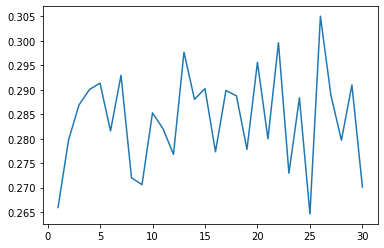

In [11]:
#################
#Explore LDA iterations
print(coherence_scores)

#Plot LDA iterations
plt.plot(range(1,31), coherence_scores)
plt.show()

# LDA Model Interpretation

## Choosing Best Model


The initial idea I got from online was to use the elbow method - coherence should get better as num_topics increases, you pick the point at which there appear to be diminishing returns to adding more topics. However, in this case that doesn't seem to be appropriate. There is a peak at 5 that has low topics and pretty high topic coherence (about 0.013 away from the peak at 26 topics), so I'm going with that.

## Coherence score results

Ok coherence scores are bad - at around 0.3. There doesn't seem to be very coherent topics that emerge from our model.

According to friendly guy [from SO](https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad):
* .3 is bad
* .4 is low
* .55 is okay
* .65 might be as good as it is going to get

## Initial analysis of topic word weightings

### Notes

* [The word 'u' likely refers to 'us' - 'us' gets lemmatised into u](https://stackoverflow.com/questions/54784287/nltk-wordnetlemmatizer-processes-us-as-u). This is how it's reported in my paper.
* Topic 5 in pyLDAvis is topic 0 in the gensim output. One can see this by comparing the gensim output for topic 0 with the Top 30 most salient terms list in the pyLDAvis graphic when λ = 1.

### Visualisation with pyLDAvis

* Blue Bars - Overall term frequency
* Red Bars - Frequency of Each word given a topic
* Lambda - Roughly, ratio of red to blue
* Can hover over a word and see what other topics use the same word
* See - http://www.kennyshirley.com/LDAvis/ and http://qpleple.com/word-relevance/
* Also see https://www.youtube.com/watch?v=IksL96ls4o0 for video demo

In all, the visualisation allows you to see not just most frequent words in the topics but also relative importance of words between topics. I find it difficult to interpret and it appears that insights drawn from it must come from its interactive use. Hence, not relying on it for now.

### The topics

With low topic coherence scores, it is hard to see immediately what the topics are about, but an effort still can be made. See the results section of the paper for the final interpretation I've made. Here are my notes for an initial interpretation:

1. "heart", "forever", "loving", "soul", "kindness", "man", "wicked", "praise" - People's "hearts" and souls singing praise to God who is loving kind, deals with the wicked. Suggests proclamation of God in line with praise form, with emphasis on nature of God
2. "kindness, "praise", "soul", "hand", "loving", "forever", "people", "heart - High overlap with 1 in terms and intertopic distance. Suggests this topic is largely about the same praise theme

At low lambdas (0.26), 1 and 2 are differentiated by 1 having more emphasis on the comfort and mercy of God - refuge, place, salvation, while topic 2 has the word "mouth" that adds little differentiation beyond what is doing the praising, and the "law"/"statute".

3. "praise", "earth", "us", "people", "hand", "name", "soul" - People, soul, and earth praising God's name and the work of his hand. As with 1 and 2, focus on praise form, but the other side of it - the congregation proclaiming knowldge of God. This intertopic distance thing really makes sense - perhaps PC1 is God and PC2 is man?
4. "us", "people", "hand", "day", "work",  - Seems to be praised themed as well, but regarding actions of God instead of his nature in 1 and 2 - "work" of God in dealing with "enemies"
5. "hand", "people", "name", "earth", "nation", "forever", "enemy", "israel", "david" - suggests praise again, with a more stately focus of the ones praising rather than heart/soul

In [12]:
#################
#Final LDA Model

#Define num_topics
num_topics = 5

#Define Final Model
#Create model
lda_model = lda.LdaModel(corpus,
                         id2word = dictionary,
                         num_topics = num_topics,
                         random_state = 5067
                         )

#Print topics
topics = lda_model.print_topics(num_words = 8)

for topics in topics:
    print(topics)
    
# Topic coherence
coherence_model_lda = CoherenceModel(model = lda_model,
                                     texts = psalms_lemmatised,
                                     dictionary = dictionary,
                                     coherence='c_v'
                                     )

coherence_lda = coherence_model_lda.get_coherence()
print("Topic coherence: " + str(coherence_lda))

(0, '0.007*"hand" + 0.006*"people" + 0.006*"name" + 0.006*"earth" + 0.005*"nation" + 0.005*"forever" + 0.005*"enemy" + 0.005*"israel"')
(1, '0.012*"heart" + 0.010*"forever" + 0.008*"loving" + 0.008*"soul" + 0.007*"kindness" + 0.007*"man" + 0.006*"wicked" + 0.006*"praise"')
(2, '0.021*"praise" + 0.012*"earth" + 0.010*"u" + 0.009*"people" + 0.009*"hand" + 0.007*"name" + 0.006*"soul" + 0.006*"day"')
(3, '0.011*"u" + 0.008*"people" + 0.008*"hand" + 0.006*"day" + 0.006*"work" + 0.005*"name" + 0.005*"enemy" + 0.005*"heart"')
(4, '0.011*"kindness" + 0.010*"praise" + 0.009*"soul" + 0.009*"hand" + 0.009*"loving" + 0.007*"forever" + 0.007*"people" + 0.007*"heart"')
Topic coherence: 0.29133079919341426


In [13]:
#################
#Visualise topics

#This is why I ended up using ipynb - pyLDAvis only works in ipynb.

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics = True)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.016835 -0.004875       1        1  39.548729
4     -0.015549  0.000818       2        1  29.131311
2     -0.006588  0.019035       3        1  16.015556
3      0.001269 -0.017037       4        1   8.515903
0      0.037703  0.002060       5        1   6.788497, topic_info=    Category        Freq      Term       Total  loglift  logprob
325  Default  157.000000    praise  157.000000  30.0000  30.0000
96   Default   96.000000         u   96.000000  29.0000  29.0000
70   Default  105.000000    people  105.000000  28.0000  28.0000
310  Default  120.000000      hand  120.000000  27.0000  27.0000
52   Default  115.000000     earth  115.000000  26.0000  26.0000
224  Default   98.000000      name   98.000000  25.0000  25.0000
68   Default   58.000000    nation   58.000000  24.0000  24.0000
535  Default   51.000000    israel   51.000000  23.0000  23.0000
118  Default   74.000000     enemy   74.000000  22.0000  22.0000
6    Default   90.000000       day   90.000000  21.0000  21.0000
65   Default   55.000000      king   55.000000  20.0000  20.0000
377  Default   63.000000      work   63.000000  19.0000  19.0000
485  Default   49.000000     child   49.000000  18.0000  18.0000
164  Default   62.000000      make   62.000000  17.0000  17.0000
184  Default   21.000000    turned   21.000000  16.0000  16.0000
117  Default   78.000000     david   78.000000  15.0000  15.0000
513  Default   40.000000      keep   40.000000  14.0000  14.0000
128  Default   63.000000       one   63.000000  13.0000  13.0000
32   Default   47.000000     water   47.000000  12.0000  12.0000
162  Default   40.000000      long   40.000000  11.0000  11.0000
598  Default   44.000000        go   44.000000  10.0000  10.0000
83   Default   46.000000       set   46.000000   9.0000   9.0000
194  Default   71.000000      come   71.000000   8.0000   8.0000
165  Default   62.000000       men   62.000000   7.0000   7.0000
123  Default   40.000000      help   40.000000   6.0000   6.0000
427  Default   29.000000      time   29.000000   5.0000   5.0000
103  Default   32.000000      zion   32.000000   4.0000   4.0000
222  Default   59.000000     mouth   59.000000   3.0000   3.0000
33   Default   61.000000       way   61.000000   2.0000   2.0000
896  Default   18.000000  covenant   18.000000   1.0000   1.0000
..       ...         ...       ...         ...      ...      ...
427   Topic5    3.529448      time   29.543327   0.5652  -5.7697
310   Topic5    8.357232      hand  120.775612   0.0191  -4.9078
224   Topic5    7.148160      name   98.053749   0.0713  -5.0640
102   Topic5    2.518173       yet   17.853991   0.7312  -6.1074
70    Topic5    7.163313    people  105.722412  -0.0019  -5.0619
164   Topic5    5.179626      make   62.547623   0.1987  -5.3862
249   Topic5    3.082296      back   26.666391   0.5322  -5.9052
118   Topic5    5.540599     enemy   74.548607   0.0906  -5.3188
65    Topic5    4.689553      king   55.896576   0.2118  -5.4855
370   Topic5    3.520687       sea   33.918110   0.4246  -5.7722
52    Topic5    6.845160     earth  115.311760  -0.1342  -5.1073
598   Topic5    3.958081        go   44.844810   0.2625  -5.6551
117   Topic5    5.265241     david   78.709297  -0.0147  -5.3698
165   Topic5    4.613170       men   62.560974   0.0827  -5.5020
128   Topic5    4.461914       one   63.113865   0.0406  -5.5353
169   Topic5    2.436924     peace   18.996414   0.6364  -6.1401
394   Topic5    5.637118   forever  120.589760  -0.3731  -5.3015
55    Topic5    4.588718      give   88.193199  -0.2660  -5.5073
6     Topic5    4.563314       day   90.998718  -0.3029  -5.5128
32    Topic5    3.492248     water   47.636738   0.0769  -5.7803
15    Topic5    4.249694       man   87.461510  -0.3344  -5.5840
194   Topic5    3.839118      come   71.578491  -0.2356  -5.6856
133   Topic5    3.173901       say   36.498428   0.2476  -5.8759
158 

## Analysis of psalm types using topic dominance

* Extract most dominant topic for each psalm
* Put this, and the weighting for that topic + other topics into a pandas DF - this allows filtering for interpretation in the paper
* Plaintext version that is easier to navigate than pandas DF
* Generate output that clearly shows the psalms grouped by their dominant topic
* Calculate which psalms have an overwhelming dominant topic weightage (75% or above) for discussion in presentation and paper.

Note:
* Because of the way we used re.split() earlier - element 0 in the lists containing all our psalms are blank. I left this alone since it helps me - Psalm 1 is 1, Psalm 2 is 2 and so on. Hence also why in the DF below, it has no dominant topic - all topics are weighted for it equally.

In [14]:
#################
#Sorting psalms by topics

#Initialise Dataframe to contain our data
psalm_dom_topics = pd.DataFrame()

#For loop to iterate through the psalms, get the most dominant topic and their weightings
for psalm in range(len(corpus)):
    
    #Get the topics
    psalm_topics = lda_model.get_document_topics(corpus[psalm])
    
    #Sort the topics by weightage
    psalm_topics_sorted = sorted(psalm_topics,
                                 key = lambda x: x[1],
                                reverse = True
                                )
    #Create dictionary of the stuff we want for each psalm
    entry = {'Psalm': psalm,
             'Dominant Topic': psalm_topics_sorted[0][0],
             'Dominant Topic Weightage': psalm_topics_sorted[0][1],
             'Topic weightings': psalm_topics_sorted
            }
    
    #Append to main DF
    psalm_dom_topics = psalm_dom_topics.append(entry, ignore_index = True)

#Make sure our columns are arranged in the right order
psalm_dom_topics = psalm_dom_topics[['Psalm', 'Dominant Topic', 'Dominant Topic Weightage', 'Topic weightings']]

#Print the head
psalm_dom_topics.head(151)

,Psalm,Dominant Topic,Dominant Topic Weightage,Topic weightings
0,0.0,0.0,0.200000,"[(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0..."
1,1.0,2.0,0.983317,"[(2, 0.98331743)]"
2,2.0,0.0,0.672701,"[(0, 0.6727008), (1, 0.21598905), (2, 0.106373..."
3,3.0,3.0,0.936148,"[(3, 0.9361479), (1, 0.052038033)]"
4,4.0,4.0,0.987381,"[(4, 0.98738134)]"
5,5.0,1.0,0.774939,"[(1, 0.77493924), (4, 0.21812232)]"
6,6.0,1.0,0.987771,"[(1, 0.9877709)]"
7,7.0,1.0,0.721476,"[(1, 0.72147626), (2, 0.2738218)]"
8,8.0,4.0,0.986808,"[(4, 0.98680806)]"
9,9.0,1.0,0.994181,"[(1, 0.9941812)]"


In [15]:
psalm_dom_topics[psalm_dom_topics['Dominant Topic'] == 4]

,Psalm,Dominant Topic,Dominant Topic Weightage,Topic weightings
4,4.0,4.0,0.987381,"[(4, 0.98738134)]"
8,8.0,4.0,0.986808,"[(4, 0.98680806)]"
22,22.0,4.0,0.996006,"[(4, 0.9960058)]"
29,29.0,4.0,0.989511,"[(4, 0.98951083)]"
30,30.0,4.0,0.851397,"[(4, 0.8513967), (2, 0.14094439)]"
35,35.0,4.0,0.995938,"[(4, 0.99593806)]"
42,42.0,4.0,0.991503,"[(4, 0.9915031)]"
50,50.0,4.0,0.994391,"[(4, 0.9943912)]"
55,55.0,4.0,0.934431,"[(4, 0.93443084), (0, 0.039850064), (1, 0.0232..."
57,57.0,4.0,0.655765,"[(4, 0.6557651), (1, 0.33811593)]"


In [16]:
#This plaintext version allows us to see the weightings more clearly than in the DF preview. Annoyingly without a proper variable inspector in
#Jupyter, this is what we have to make do with

for psalm in range(len(corpus)):
    print("Psalm number " + str(psalm) + ": " +
          str(lda_model.get_document_topics(corpus[psalm])))

Psalm number 0: [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
Psalm number 1: [(2, 0.98332083)]
Psalm number 2: [(0, 0.6722805), (1, 0.20307428), (2, 0.11970878)]
Psalm number 3: [(1, 0.060666576), (3, 0.92752)]
Psalm number 4: [(4, 0.9873812)]
Psalm number 5: [(1, 0.7807771), (4, 0.2122844)]
Psalm number 6: [(1, 0.9877719)]
Psalm number 7: [(1, 0.7194086), (2, 0.27588946)]
Psalm number 8: [(4, 0.98680794)]
Psalm number 9: [(1, 0.9911753)]
Psalm number 10: [(1, 0.9938807)]
Psalm number 11: [(1, 0.9857265)]
Psalm number 12: [(1, 0.98746437)]
Psalm number 13: [(1, 0.98139983)]
Psalm number 14: [(1, 0.43813112), (2, 0.5507253)]
Psalm number 15: [(1, 0.98102194)]
Psalm number 16: [(1, 0.9449712), (4, 0.047469396)]
Psalm number 17: [(1, 0.5068981), (2, 0.10879846), (4, 0.38093895)]
Psalm number 18: [(1, 0.9772681), (3, 0.020911952)]
Psalm number 19: [(1, 0.99280995)]
Psalm number 20: [(1, 0.9870416)]
Psalm number 21: [(1, 0.93255746), (2, 0.060703944)]
Psalm number 22: [(4, 0.9960054)]

In [17]:
#Initialise blank list
psalms_by_topic = []

for topic in range(num_topics):
    
    #Filter the DF by dominant topic
    df_filter_dom_topic = psalm_dom_topics[psalm_dom_topics['Dominant Topic'] == topic]
    
    #Put it in our list
    psalms_by_topic.append(df_filter_dom_topic['Psalm'])

In [18]:
for topic in range(num_topics):
    print("Topic: " + str(topic) + "\n" +
          psalms_by_topic[topic].to_string(index = False) +
          "\n\n"
         )

Topic: 0
   0.0
   2.0
  78.0
  83.0
  93.0
 110.0
 114.0
 122.0
 125.0
 127.0
 129.0


Topic: 1
   5.0
   6.0
   7.0
   9.0
  10.0
  11.0
  12.0
  13.0
  15.0
  16.0
  17.0
  18.0
  19.0
  20.0
  21.0
  23.0
  24.0
  25.0
  26.0
  27.0
  28.0
  31.0
  32.0
  33.0
  34.0
  36.0
  37.0
  39.0
  40.0
  43.0
  48.0
  49.0
  51.0
  52.0
  53.0
  59.0
  61.0
  62.0
  64.0
  66.0
  73.0
  76.0
  84.0
  90.0
  92.0
  94.0
  97.0
  99.0
 101.0
 102.0
 104.0
 105.0
 106.0
 109.0
 112.0
 131.0
 132.0
 140.0
 142.0
 143.0


Topic: 2
   1.0
  14.0
  45.0
  46.0
  47.0
  56.0
  58.0
  67.0
  68.0
  71.0
  72.0
  75.0
  77.0
  79.0
  85.0
  91.0
  96.0
  98.0
 113.0
 117.0
 120.0
 121.0
 123.0
 124.0
 128.0
 134.0
 135.0
 145.0
 146.0
 147.0
 148.0
 149.0
 150.0


Topic: 3
   3.0
  38.0
  41.0
  44.0
  54.0
  60.0
  70.0
  74.0
  80.0
 108.0
 111.0
 126.0
 137.0


Topic: 4
   4.0
   8.0
  22.0
  29.0
  30.0
  35.0
  42.0
  50.0
  55.0
  57.0
  63.0
  65.0
  69.0
  81.0
  82.0
  86.0
  87.0
  88.0
  

In [19]:
#Number of psalms with less than 0.75 dominant topic weightage
sum(psalm_dom_topics["Dominant Topic Weightage"] <= 0.75) - 1

27